### This model uses a pretrained convnet (VGG16 trained via ImageNet) to do feature extraction without data augmentation.

In [1]:
from keras import layers, models, optimizers
from keras.applications import VGG16
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = '/Users/camargo/Projects/deeplearning/data/dogs-vs-cats-small'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

In [3]:
batch_size = 20
datagen = image.ImageDataGenerator(rescale=1./255)

In [4]:
conv_base = VGG16(
    include_top=False,
    input_shape=(150, 150, 3),
    weights='imagenet'
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [20]:
def extract_features(directory: str, sample_count: int):
    """
    Run VGG16 (our convolutional base) over entire dataset and
    record the output to a Numpy array.
    """
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    batch_generator = datagen.flow_from_directory(
        directory,
        batch_size=batch_size,
        class_mode='binary',
        target_size=(150, 150),
    )
    i = 0
    for inputs_batch, labels_batch in batch_generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
print(f'train_features: {train_features.shape}')
print(f'train_labels: {train_labels.shape}')
print(f'validation_features: {validation_features.shape}')
print(f'validation_labels: {validation_labels.shape}')
print(f'test_features: {test_features.shape}')
print(f'test_labels: {test_labels.shape}')

train_features: (2000, 4, 4, 512)
train_labels: (2000,)
validation_features: (1000, 4, 4, 512)
validation_labels: (1000,)
test_features: (1000, 4, 4, 512)
test_labels: (1000,)


In [23]:
train_features_flat = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features_flat = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features_flat = np.reshape(test_features, (1000, 4 * 4 * 512))

In [24]:
print(f'train_features_flat: {train_features_flat.shape}')
print(f'validation_features_flat: {validation_features_flat.shape}')
print(f'test_features_flat: {test_features_flat.shape}')

train_features_flat: (2000, 8192)
validation_features_flat: (1000, 8192)
test_features_flat: (1000, 8192)


In [25]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
model.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
)

In [28]:
history = model.fit(
    train_features_flat,
    train_labels,
    batch_size=batch_size,
    epochs=30,
    validation_data=(validation_features_flat, validation_labels)
)

Epoch 1/30
100/100 [==============================] - 2s 17ms/step - loss: 0.6242 - acc: 0.6350 - val_loss: 0.4694 - val_acc: 0.8210
Epoch 2/30
100/100 [==============================] - 2s 15ms/step - loss: 0.4384 - acc: 0.8010 - val_loss: 0.3784 - val_acc: 0.8570
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3815 - acc: 0.8310 - val_loss: 0.3385 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 1s 15ms/step - loss: 0.3333 - acc: 0.8670 - val_loss: 0.3238 - val_acc: 0.8620
Epoch 5/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2977 - acc: 0.8830 - val_loss: 0.2982 - val_acc: 0.8800
Epoch 6/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2667 - acc: 0.8900 - val_loss: 0.2871 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2557 - acc: 0.8920 - val_loss: 0.2744 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

In [29]:
model.save('cats-vs-dogs-convnet-v3.h5')

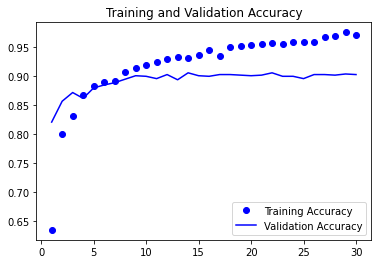

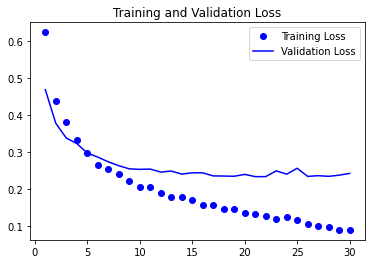

In [30]:
loss = history.history.get('loss')
acc = history.history.get('acc')
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [31]:
model.evaluate(test_features_flat, test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.2584 - acc: 0.8950


[0.2584058940410614, 0.8949999809265137]